### Gender Classification

In this tutorial, we are going to fine-tune the pre-trained VGG-Face descriptors for the task of classifying the gender of a person from his/her face image. As we saw in the previous tutorial, the VGG-Face network has been trained to recognize 2,622 celebrity IDs. Also, we can ignore/chop-off the classification layer of the network and treat the output of the fc-layer as a representation for the input face. We are going to learn a new Softmax  classification layer on top of these fc layer features and train it to classify the gender of the input face image into one of the two classes -- "male" and "female". By the end of this tutorial, the participants would appreciiate the fact that by minimal amount of fine-tuning, the pre-trained VGG-Face representations can be made useful for a variety of tasks that are different from the original task that the representations were learnt from i.e. face recognition.

In [1]:
import cv2, math
import numpy as np
import os
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader
import torchvision.models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
plt.ion()

In [2]:
root = 'data'
eroot = os.path.join(root, 'Experiment_2')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Dataset
We are going to use a subset of the CelebA dataset for our experiment. CelebA is a large-scale celebrity face attributes dataset. It consists of more than 200k celebrity face images, each having 40 binary face attribute annotations, with gender being one of them. We have selected a random subset of 200 face images -- 100 male and female faces each for the purpose of this experiment. Let us take a look at the distribution of the training and test splits.

In [3]:
with open(os.path.join(eroot, 'celeba-gender-dataset.json')) as f:
	data = json.load(f)

print('# images in trainset = ', data['train']['size'])
print('# images in test set = ', data['test']['size'])


# images in trainset =  160
# images in test set =  40


Let us take a look at some of the faces in the dataset, and their asosciated labels.

label =  1


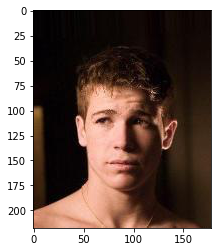

In [4]:
imgPath = os.path.join(eroot, data['train']['imgPaths'][0])
imgLabel = data['train']['labels'][0]

print("label = ", imgLabel)
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)

`label=0` stands for "male" whereas `label=1` stands for female. Let us also take a look at an example of a female face image in our training set.

label =  0


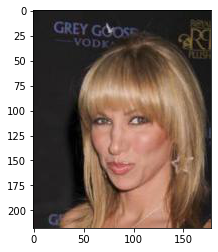

In [5]:
imgPath = os.path.join(eroot, data['train']['imgPaths'][100])
imgLabel = data['train']['labels'][100]

print("label = ", imgLabel)
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)

We have 160 training and 40 test images with each set having an equal distribution of male and female faces. Participants are encouraged to modify the code and view some of the different face images (and their asosciated labels) in the training as well as test sets.



### Feature extraction

We are using the VGG-Face pretrained network for feature extraction. Here, we load the network and create a function for extracting the features.

In [6]:
def loadVGGModel( filename):
	dat2 = torch.load(filename)
	# copy dictionary
	if str.split(list(dat2.keys())[0],'.')[0] == 'module':
		dat = {}
		for key in dat2.keys():
			k = '.'.join(str.split(key,'.')[1:])
			dat[k] = dat2[key]
	else:
		dat = dat2
		
	n_classes = dat['classifier.6.bias'].shape[0]
	model = torchvision.models.vgg16(pretrained = False)
	lastlayer = torch.nn.Linear(in_features = model.classifier[-1].in_features, \
							   out_features = n_classes, \
							   bias = True)
	model.classifier[-1] = lastlayer
	model.load_state_dict(dat)
	return model

def getFeature(x, model):
	# replicate the forward function
	x = model.features(x)
	x = model.avgpool(x)
	x = torch.flatten(x, 1)
	# forward pass only through the first 4 layers of the classifier
	for ii in range(4):
		x = model.classifier[ii](x)
	return x


In [7]:
vggFace = loadVGGModel(os.path.join(root, 'VGGFace16.pth'))
vggFace = vggFace.to(device)

#### Dataset class
Now we will extend the pytorch dataset class for our custom dataset. We need to implement two functions: __len__ which gives the length of the dataset, and __getitem__ which returns an item of the dataset given an index. For every image of the dataset, we are using the pretrained features. But we are not extracting them here because it is more efficient to extract them in batch.

In [8]:
def loadImage(imgPath):
    inputImg = cv2.imread(imgPath)

    # re-scale the smaller dim (among width, height) to refSize
    refSize, targetSize = 256, 224
    imgRows, imgCols = inputImg.shape[0], inputImg.shape[1]
    if imgCols < imgRows: resizedImg = cv2.resize(inputImg, (refSize, int(refSize * imgRows / imgCols)))
    else: resizedImg = cv2.resize(inputImg, (int(refSize * imgCols / imgRows), refSize))

    # center-crop
    oH, oW = targetSize, targetSize
    iH, iW = resizedImg.shape[0], resizedImg.shape[1]
    anchorH, anchorW = int(math.ceil((iH - oH)/2)), int(math.ceil((iW - oW) / 2))
    croppedImg = resizedImg[anchorH:anchorH+oH, anchorW:anchorW+oW]

    # convert shape from (height, width, 3) to (3, width, height)
    channel_1, channel_2, channel_3 = croppedImg[:, :, 0], croppedImg[:, :, 1], croppedImg[:, :, 2]
    croppedImg = np.empty([3, croppedImg.shape[0], croppedImg.shape[1]])
    croppedImg[0], croppedImg[1], croppedImg[2] = channel_1, channel_2, channel_3

    # subtract training mean
    inputImg = inputImg.astype(float)
    trainingMean = [129.1863, 104.7624, 93.5940]
    for i in range(3): croppedImg[i] = croppedImg[i] - trainingMean[i]
    return croppedImg

class GenderDataset(Dataset):
	def __init__(self, data):
		self.labels = data['labels']
		self.imgPaths = data['imgPaths']
		self.size = data['size']
	
	def __len__(self):
		return self.size
	
	def __getitem__(self, index):
		label = self.labels[index]
		imgpath = os.path.join(eroot, self.imgPaths[index])
		img = loadImage(imgpath)
		return torch.tensor(img, dtype= torch.float32), label
		
		

### Network Architecture
Having defined the functions for pre-processing images and getting the pre-trained face descriptors, let us take a look at the network structure that we are going to train.

In [9]:
# Network structure that we'll train for gender classification

class Net(torch.nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.fc1 = torch.nn.Linear(4096, 2048)
		self.fc2 = torch.nn.Linear(2048, 2)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


The architecture is quite straightforward. We have two linear layers:  ```Linear(4096, 2048)``` and ```Linear(2048,2)```   which takes a 4096-d input and computes a vector that has two elements. Recall from the previous tutorial that the pre-trained VGG-Face descriptors are 4096-d in size. So, our fc-layers can take the pre-trained descriptors as input and return a pair of values which would be the (unnormalized) likelihoods of the input image belonging to each of the two classes -- "male" and "female".

The first fc-layer is followed by a ```ReLu``` layer as the linearity. By training the parameters of the fc-layer to minimize the loss, our network will learn to map the pre-trained face descriptors to the correct gender class.

### Training
Now that we have fixed the network architecture as well as the dataset, let us move on to training our network on the dataset. We are going to use a combination of `LogSoftMax` + `NLLLoss` in PyTorch to train the network. Let us take a look at the various steps involved.

First of all, we fix the seed of the various random number generators that our code uses. Why do we need to do this? So that, all are experimental results are reproducible. Having fixed the seed, our network parameters will always be initialized with the same random values every time we run the experiments. Also, the sampling of the mini-batch during training will also follow the same order in different runs of the experiment. You can verify this fact by commenting out the 2 lines given below and comparing the value of the training loss in successive runs of the experiment.

In [10]:
# fix the seeds of random number generators
torch.manual_seed(0)
np.random.seed(0)

Next, we create the dataset. We also initialize our network architecture, loss module and certain other training parameters such as number of epochs to train and the batch size.

In [11]:
traindataset = GenderDataset(data['train'])
testdataset = GenderDataset(data['test'])

# initialize the net, loss and optimizer (SGD)
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
nEpochs, batchSize = 10, 10

net = net.to(device)

Before we jump into the training code, we would first define a function that lets us evaluate how good our model is performing on the test dataset.

In [12]:
def Evaluate(net, dataset):
	dataloader = DataLoader(dataset, batch_size = batchSize, shuffle=True)
	correct = 0
	total = 0
	with torch.no_grad():
		for ii, dat in enumerate(dataloader):
			# unpack the data
			imgs, labels = dat
			feats = getFeature(imgs.to(device), vggFace)
			output = F.log_softmax(net(feats.to(device)))
			predictions = np.argmax(output.detach().cpu(), 1)
			correct += (predictions==labels).sum().item()
			total += len(labels)
	return correct/total
		

Let us see the performance of our (un-trained) network on the test set by calling the `evaluate()` function.

In [13]:
print("accuracy (before training) = ", Evaluate(net, testdataset))

accuracy (before training) =  0.55


<ipython-input-12-cbdbfc2f74b4>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(net(feats.to(device)))


As you can see, the overall classification accuracies are quite low. At the moment, the network is performing only slightly better than a random assignment of classes. This is to be expected because the parameters of the network are randomly initialized and no training has been done till now.

Let us see the code for training the network now.

In [14]:
def train(dataset, net, optimizer, criterion, nepochs):
	dataloader = DataLoader(dataset, batch_size = batchSize, shuffle=True)
	for epoch in range(nepochs):
		running_loss = 0.0
		for ii, (imgs, labels) in enumerate(dataloader):
			with torch.no_grad(): # we will not be back-propagating this
				feats = getFeature(imgs.to(device), vggFace)
			output = net(feats)
			optimizer.zero_grad()
			loss = criterion(output, labels.to(device))
			loss.backward()
			optimizer.step()
			running_loss+=loss.item()
		print(f'epoch {epoch} running_loss : {running_loss/ii}', flush=True)
		
		
	

In [15]:
train(traindataset, net, optimizer, criterion, nEpochs)

epoch 0 running_loss : 1.7032159010569254
epoch 1 running_loss : 0.305260764186581
epoch 2 running_loss : 0.19757173684968923
epoch 3 running_loss : 0.101565826854979
epoch 4 running_loss : 0.0656986231682822
epoch 5 running_loss : 0.015667679505228686
epoch 6 running_loss : 0.005080386305538317
epoch 7 running_loss : 0.01075473671250317
epoch 8 running_loss : 0.01261013999064744
epoch 9 running_loss : 0.005832740712988501


Having trained the network, let us see if the performance on the test set has improved over what we got prior to training. 

In [16]:
print("accuracy (after training) = ", Evaluate(net, testdataset))

accuracy (after training) =  0.95


<ipython-input-12-cbdbfc2f74b4>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(net(feats.to(device)))


As you can see, there is a significant jump in performance after training for just 1 epoch (16 iterations).

Let us see our network in action as it classifies individual images from the test set. Recall that `label=1` denotes "male" whereas `label=0` denotes female.

true label =  1
predicted label =  1


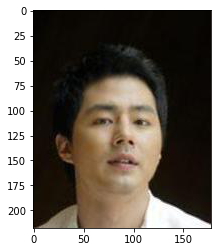

In [17]:
index = 0
imgPath = os.path.join(eroot, data['test']['imgPaths'][index])
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)
imgLabel = data['test']['labels'][index]
print("true label = ", imgLabel)

features = getFeature(testdataset[index][0].unsqueeze(0).to(device), vggFace)
output = net(features).to(device).data.cpu().numpy()
print("predicted label = ", np.argmax(output, 1)[0])

true label =  0
predicted label =  0


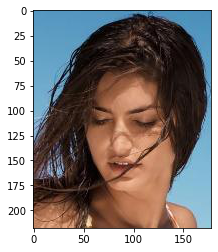

In [18]:
index = 31
imgPath = os.path.join(eroot, data['test']['imgPaths'][index])
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)
imgLabel = data['test']['labels'][index]
print("true label = ", imgLabel)

features = getFeature(testdataset[index][0].unsqueeze(0).to(device), vggFace)
output = net(features).to(device).data.cpu().numpy()
print("predicted label = ", np.argmax(output, 1)[0])